In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

!pip install pygraphviz --install-option="--include-path=/usr/include/graphviz" --install-option="--library-path=/usr/lib/graphviz/"

from networkx.drawing.nx_agraph import graphviz_layout

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-_e3xeen4
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-_e3xeen4
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
  Using cached pygraphviz-1.7

In [3]:
import os, sys
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime
import warnings
from math import sin, cos, sqrt, atan2, radians, pi
import networkx as nx
from shapely.geometry import Point, LineString
import requests
import json
sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

In [4]:
latest_congestion = pd.read_csv('/content/drive/My Drive/project/Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments.csv')
latest_congestion.head(4)

,SEGMENTID,STREET,DIRECTION,FROM_STREET,TO_STREET,LENGTH,STREET_HEADING,COMMENTS,START_LONGITUDE,START_LATITUDE,END_LONGITUDE,END_LATITUDE,CURRENT_SPEED,LAST_UPDATED
0,1284,Chicago,WB,Lake Shore Dr,Michigan,0.370000,E,NaN,-87.617048,41.896936,-87.624241,41.896835,-1,2011-08-10 00:00:00.0
1,951,Washington,WB,Kedzie,Schraeder,0.280000,W,NaN,-87.706169,41.882932,-87.711747,41.882818,-1,2010-07-21 14:51:00.0
2,750,Elston,SE,Milwaukee,Austin,0.330000,N,NaN,-87.783224,41.992665,-87.778073,41.989905,-1,2010-07-21 14:51:10.0
3,1164,Harlem,SB,Ogden,Pershing,0.173023,S,Outside City Limits,-87.802922,41.823751,-87.803025,41.821245,-1,2010-07-21 14:51:15.0


In [5]:
#Define MapNode
class MapNode:
  def __init__(self, id, segment_id, street, direction, from_street, to_street, length, street_heading, 
               comments, start_longitude, start_latitude, end_longitude, end_latitude, current_speed):
    self.id = id
    self.segment_id = segment_id
    self.street = street
    self.direction = direction
    self.from_street = from_street
    self.to_street = to_street
    self.length = length
    self.street_heading = street_heading
    self.comments = comments
    self.start_longitude = start_longitude
    self.start_latitude = start_latitude
    self.end_longitude = end_longitude
    self.end_latitude = end_latitude
    self.current_speed = current_speed
    self.connected_to = []
    self.connected_from = []
    self.stops = []

  #Uses haversine formula to calculate distance between two lat long points
  #http://www.movable-type.co.uk/scripts/latlong.html
  def distance_split(lat1, lon1, lat2, lon2):
    R = 3959 #Earth's radius in miles
    theta1 = lat1 * pi/180
    theta2 = lat2 * pi/180
    delta_theta = (lat2 - lat1) * pi/180
    delta_lambda = (lon2 - lon1) * pi/180
    a = sin(delta_theta/2) * sin(delta_theta/2) + cos(theta1) * cos(theta2) * sin(delta_lambda/2) * sin(delta_lambda/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

  #Splitting necessary as a road segment may not stop at every intersection, see intersection of Michigan and Balbo
  def split(node, connection, next_id, network):
    distance_first = MapNode.distance_split(node.start_latitude, node.start_longitude, connection.end_latitude, connection.end_longitude)
    distance_second = node.length - distance_first
    second = MapNode(next_id, node.segment_id, node.street, node.direction, connection.street, node.to_street, distance_second, node.street_heading, 
                     node.comments, connection.end_latitude, connection.end_longitude, node.end_latitude, node.end_longitude, node.current_speed)
    node.to_street = connection.street
    node.length = distance_first
    second.connected_to = node.connected_to
    second.connected_from.append(node.id)
    #update connected_to lists
    for curr_id in second.connected_to:
      curr = network[curr_id]
      curr.connected_from.remove(node.id)
      curr.connected_from.append(second.id)

    node.connected_to = [second.id]
    network.append(second)
    return second

#Gets the street id for the given street, if the street id is not in the street_id_dict it is newly added
#Also manages the list of nodes associated with a street, a street is only added to the list if the segment is located on the actual street, not going to it or coming from it
def get_street_id(street, next_street_id, street_id_dict, street_list_dict, next_id, is_actual):
  street = street.upper() #convert to upper case for comparison to other datasets
  if street in street_id_dict:
    if is_actual:
      street_list_dict[street_id_dict[street]][1].append(next_id)
    return street_id_dict[street], next_street_id
  else:
    street_id_dict[street] = next_street_id
    if is_actual:
      street_list_dict[next_street_id] = (street, [next_id])
    else:
      street_list_dict[next_street_id] = (street, [])
    return next_street_id, next_street_id + 1

In [6]:
#Extract nodes from DataFrame
next_id = 0
network = []
street_id_dict = dict()
street_list_dict = dict()
next_street_id = 0
for index, row in latest_congestion.iterrows():
  street_id, next_street_id = get_street_id(row['STREET'], next_street_id, street_id_dict, street_list_dict, next_id, True)
  to_street_id, next_street_id = get_street_id(row['TO_STREET'], next_street_id, street_id_dict, street_list_dict, next_id, False)
  from_street_id, next_street_id = get_street_id(row['FROM_STREET'], next_street_id, street_id_dict, street_list_dict, next_id, False)

  node = MapNode(next_id, row['SEGMENTID'], street_id, row['DIRECTION'], from_street_id, to_street_id, row['LENGTH'], row[' STREET_HEADING'], 
                 row[' COMMENTS'], row[' START_LATITUDE'], row['START_LONGITUDE'], row[' END_LATITUDE'], row['END_LONGITUDE'], row[' CURRENT_SPEED'])
  network.append(node)
  next_id += 1

#Connect edges bewteen nodes
for node in network:
  cross_street = False
  for cand_id in street_list_dict[node.street][1]:
    cand = network[cand_id]
    #find segment on same street
    if node.to_street == cand.from_street and node.id != cand.id:
      node.connected_to.append(cand.id)
      cand.connected_from.append(node.id)
  for cand_id in street_list_dict[node.to_street][1]:
    cand = network[cand_id]
    #find segment from the intersection
    if cand.from_street == node.street and node.id != cand.id:
      node.connected_to.append(cand.id)
      cand.connected_from.append(node.id)
      cross_street = True
  
  #If there are no other cross street segments, likely need to break up a segment
  if not cross_street:
    segments_split = []
    for cand_id in street_list_dict[node.to_street][1]:
        cand = network[cand.id]
        if cand.segment_id not in segments_split:
          if node.direction == 'WB' or node.direction == 'EB':
            node_compare = node.end_latitude
            cand_compare_start = cand.start_latitude
            cand_compare_end = cand.end_latitude
          else:
            node_compare = node.end_longitude
            cand_compare_start = cand.start_longitude
            cand_compare_end = cand.end_longitude

          if (node_compare < cand_compare_end and node_compare > cand_compare_start) or (node_compare > cand_compare_end and node_compare < cand_compare_start):
            second = MapNode.split(cand, node, next_id, network)
            segments_split.append(cand.segment_id)
            street_list_dict[second.street][1].append(next_id)
            next_id += 1

    

0.0018211837694501426


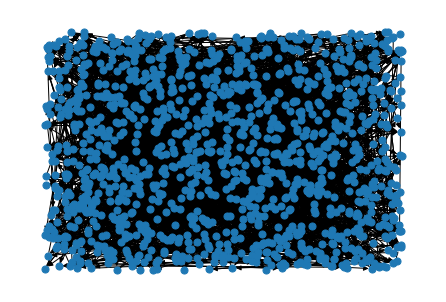

In [201]:
#Port custom map nodes into NetworkX
graph =  nx.DiGraph()
graph.add_nodes_from(range(next_id-1)) #add all node IDs
for node in network:
  for connec in node.connected_to:
    graph.add_edge(node.id, connec)
pos=nx.random_layout(graph)
print(nx.density(graph))
nx.draw(graph, pos=pos, node_size=50)
#Visualize road segment network

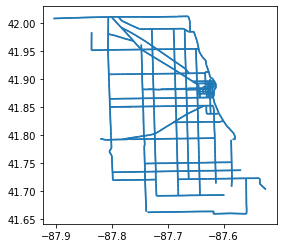

In [7]:
latest_congestion_start_geo = gpd.points_from_xy(latest_congestion['START_LONGITUDE'], latest_congestion[' START_LATITUDE'])
latest_congestion_end_geo = gpd.points_from_xy(latest_congestion['END_LONGITUDE'], latest_congestion[' END_LATITUDE'])
data = []
for index, row in latest_congestion.iterrows():
  ls = LineString([Point(row['START_LONGITUDE'], row[' START_LATITUDE']), Point(row['END_LONGITUDE'], row[' END_LATITUDE'])])
  data.append(ls)
latest_congestion_geo = gpd.GeoDataFrame(latest_congestion, geometry=data)
latest_congestion_geo.plot()

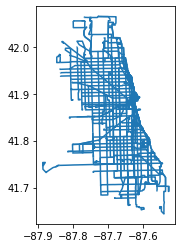

In [8]:
bus_routes_geo = gpd.read_file('/content/drive/My Drive/project/CTA_BusRoutes/CTA_BusRoutes.shp')
bus_routes_geo = bus_routes_geo.to_crs("EPSG:4326") #Convert given values to traditional Latitude and Longitude values used in other CTA datasets
bus_routes_geo = bus_routes_geo.loc[bus_routes_geo['WKDAY'] == 1]
bus_routes_geo.plot()

In [9]:
bus_usage_2012 = pd.read_csv('/content/drive/My Drive/project/CTA_-_Ridership_-_Avg._Weekday_Bus_Stop_Boardings_in_October_2012.csv')
bus_usage_2012.head(4)

,stop_id,on_street,cross_street,routes,boardings,alightings,month_beginning,daytype,location
0,1,JACKSON,AUSTIN,126,183.4,150.0,10/01/2012,Weekday,"(41.87632184, -87.77410482)"
1,2,JACKSON,MAYFIELD (EXTENDED),126,5.3,0.2,10/01/2012,Weekday,"(41.87706679, -87.77131794)"
2,3,JACKSON,MENARD,126,8.3,0.7,10/01/2012,Weekday,"(41.87695725, -87.76975039)"
3,4,JACKSON,5700 WEST,126,17.9,3.0,10/01/2012,Weekday,"(41.87702418, -87.76745055)"


In [10]:
bus_stops_geo = gpd.read_file('/content/drive/My Drive/project/CTA_BusStops/CTA_BusStops.shp')
bus_stops_geo.head(4)

,OBJECTID,SYSTEMSTOP,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,OWLROUTES,CITY,STATUS,PUBLIC_NAM,POINT_X,POINT_Y,geometry
0,28,1583.0,MICHIGAN,8TH STREET,NB,NT,"1,3,4",N4,CHICAGO,1,Michigan & 8th Street,-87.624034,41.871787,POINT (-87.62403 41.87179)
1,29,9703.0,NAGLE,BRYN MAWR,NB,NS,"86,91",None,CHICAGO,1,Nagle & Bryn Mawr,-87.787625,41.982800,POINT (-87.78763 41.98280)
2,30,6283.0,CLARK,18TH STREET,NB,NS,24,None,CHICAGO,1,Clark & 18th Street,-87.630112,41.857672,POINT (-87.63011 41.85767)
3,31,9698.0,NAGLE,FOSTER,NB,NS,"86,91",None,CHICAGO,1,Nagle & Foster,-87.787796,41.975568,POINT (-87.78780 41.97557)


In [11]:
#Define clases that encapsulate route, pattern, and bus stop data
class Route:
  def __init__(self, desig, patterns):
    self.desig = desig
    self.patterns = patterns #unordered list of route patterns, generally two directions (NB and SB or EB and WB)
    self.ridership = 0

class RoutePattern:
  def __init__(self, pid, length, direction, points):
    self.pid = pid
    self.length = length
    self.direction = direction
    self.points = points #ordered list of BusStops in a RoutePattern

class BusStop:
  def __init__(self, stopid, street, cross_st, boardings, alightings, lon, lat):
    self.stopid = stopid
    self.street = street
    self.cross_st = cross_st
    self.boardings = boardings
    self.alightings = alightings
    self.location = (lon, lat)
    self.point = Point(lon, lat)
    self.routes = set() #routes added during processing
    self.gravity = dict()
    self.assoc_directions = set()

In [12]:
#Create bus stop objects
bus_stops = dict()
for index, row in bus_usage_2012.iterrows(): #Add all bus stops with emtpy set of routes based on boarding data
  stopid = row['stop_id']
  geo_row = bus_stops_geo.loc[bus_stops_geo['SYSTEMSTOP'] == stopid]
  geo_list = geo_row.values.tolist()
  if len(geo_list) > 0:
    stop = BusStop(stopid, geo_list[0][2], geo_list[0][3], row['boardings'], row['alightings'], geo_list[0][11], geo_list[0][12])
    bus_stops[stopid] = stop

In [13]:
#Create list of all bus routes that are operated on weekdays
route_rows = []
for index, row in bus_routes_geo.iterrows(): 
  route_rows.append(row['ROUTE'])

route_json = dict()
#To get route patterns, have to utilize CTA's bus tracking API
base_patterns_api_url = "http://www.ctabustracker.com/bustime/api/v2/getpatterns?key=aXnS9CqL9k8Y3wHc2HaJCMWVW&format=json&rt="
for route in route_rows:
  route_json[route] = requests.get(base_patterns_api_url + route)


In [14]:

distance = MapNode.distance_split(downtown_center[1], downtown_center[0], centroid.y, centroid.x)#Create route objects
routes = dict()
for rte in route_json.keys(): #Create route objects
  if 'ptr' in route_json[rte].json()['bustime-response']: #needs to have a route pattern to be usable
    rte_ptrns = []
    for rte_ptrn in route_json[rte].json()['bustime-response']['ptr']: #Convert route pattern json to RoutePattern class
      points = []
      for pnt in rte_ptrn['pt']:
        if 'stpid' in pnt.keys(): #Point has a stop id
          stpid = int(pnt['stpid'])
          if stpid in bus_stops.keys():
            points.append(stpid)
            bus_stops[stpid].routes.add(rte)
            bus_stops[stpid].gravity[rte] = 0
            bus_stops[stpid].assoc_directions.add(rte_ptrn['rtdir'])
      rte_ptrns.append(RoutePattern(rte_ptrn['pid'], rte_ptrn['ln'], rte_ptrn['rtdir'], points))
    routes[rte] = Route(rte, rte_ptrns)

In [23]:
#Add average ridership per route
monthly_totals_by_route = pd.read_csv('/content/drive/My Drive/project/CTA_-_Ridership_-_Bus_Routes_-_Monthly_Day-Type_Averages___Totals.csv')
mtbr_oct_2019 = monthly_totals_by_route.loc[monthly_totals_by_route['Month_Beginning'] == '10/01/2019']
for index, row in mtbr_oct_2019.iterrows():
  if row['route'] in routes.keys():
    routes[row['route']].ridership = row['Avg_Weekday_Rides']

mtbr_oct_2019.head(4)

,route,routename,Month_Beginning,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal
31075,1,Bronzeville/Union Station,10/01/2019,1849.1,0.0,0.0,42529
31076,2,Hyde Park Express,10/01/2019,3780.4,0.0,0.0,86950
31077,3,King Drive,10/01/2019,16376.1,11425.0,7710.3,453192
31078,4,Cottage Grove,10/01/2019,19384.7,12543.7,9597.2,534412


In [24]:
#Associate bus stops with congestion segments, if a stop has no segment, then it is not a candidate for a bus lane
dir_conversion = {'WB':'Westbound', 'EB':'Eastbound', 'SB':'Southbound', 'NB':'Northbound', 'NW':'Northbound', 'NE':'Northbound', 'SW':'Southbound', 'SE':'Southbound'} #patterns use full word, segments use abbreviations
for stop in bus_stops.values():
  if stop.street in street_id_dict:
    seg_list = street_list_dict[street_id_dict[stop.street]][1]
    for seg_id in seg_list:
      seg = network[seg_id]
      seg_dir = dir_conversion[seg.direction]
      if seg_dir in stop.assoc_directions: #stop is on a route going same cardinal direction as the segment
        if seg_dir == 'Westbound' or seg.direction == 'Eastbound':
          stop_compare = stop.location[1]
          seg_start = seg.start_longitude
          seg_end = seg.end_longitude
        else:
          stop_compare = stop.location[0]
          seg_start = seg.start_latitude
          seg_end = seg.end_latitude
        if (stop_compare >= seg_start and stop_compare <= seg_end) or (stop_compare <= seg_start and stop_compare >= seg_end): #stop is within the boundaries of this segment
          seg.stops.append(stop.stopid)


In [25]:
#variables
avg_commute_length = 10
std_dev_commute = 2.5
bus_lane_speed = 30
downtown_center = (-87.648239, 41.875441)

In [26]:
#Determine candidate road segments
seg_cands = dict()
for seg in network:
  if seg.current_speed != -1 and len(seg.stops) > 0 and seg.current_speed < bus_lane_speed: #segment is a candidate for bus lanes if it has a speed measurements and has stops, and its speed isn't already faster than the bus lane speed
    seg_cands[seg.segment_id] = seg

In [36]:
#Calculation of optimal segments using only boardings and alightings
score_vals = dict()
for seg_id in seg_cands.keys():
  seg = seg_cands[seg_id]
  score_vals[seg_id] = 0
  for stop_id in seg.stops:
    stop = bus_stops[stop_id]
    if len(stop.routes) > 0:
      avg_ridership_at_stop = 0
      for rte in stop.routes:
        avg_ridership_at_stop += routes[rte].ridership
      avg_ridership_at_stop /= len(stop.routes)
    score_vals[seg_id] += (stop.boardings + stop.alightings) * avg_ridership_at_stop #scale boardings by total ridership
  score_vals[seg_id] *= (bus_lane_speed - seg.current_speed) * seg.length #scale boardings and alightings by speed and distance
max_scores = sorted(score_vals.items(), key=lambda x:x[1], reverse=True)
for i in range(100): #print top 20 segments
  seg = seg_cands[max_scores[i][0]]
  centroid = (latest_congestion_geo.loc[latest_congestion['SEGMENTID'] == seg.segment_id]).centroid
  distance = MapNode.distance_split(downtown_center[1], downtown_center[0], centroid.y, centroid.x)
  print(i + 1,": ",  street_list_dict[seg.street][0], street_list_dict[seg.to_street][0], street_list_dict[seg.from_street][0], seg.length, bus_lane_speed - seg.current_speed, distance, max_scores[i][1])

1 :  MICHIGAN OHIO RANDOLPH 0.56 12 1.5346930333830717 1334433459.6640003
2 :  MICHIGAN RANDOLPH OHIO 0.56 9 1.5191813297173107 971221360.2588003
3 :  STATE CONGRESS WACKER 0.77 10 1.1202872347445558 876952914.4530001
4 :  MICHIGAN CONGRESS ROOSEVELT 0.57 7 1.273550046476088 713292321.5836201
5 :  MICHIGAN 16TH ROOSEVELT 0.23 11 1.468624337177564 474398169.9236359
6 :  STATE WACKER CONGRESS 0.77 8 1.1299054283175014 468040440.11647993
7 :  MICHIGAN LAKE SHORE DR MICHIGAN ENTRANCE RAMP OHIO 0.84 8 1.9278940151357273 462028933.23776
8 :  ROOSEVELT CLARK LAKE SHORE DR 0.6 16 1.3276493502800208 426779725.98719996
9 :  MICHIGAN OHIO LAKE SHORE DR MICHIGAN EXIT RAMP 0.84 12 1.9140754556324941 406389857.5296
10 :  CHICAGO LASALLE HALSTED 0.77 10 1.506087022535386 399165894.974
11 :  ROOSEVELT LAKE SHORE DR CLARK 0.6 11 1.33538401000562 355189915.98419994
12 :  CHICAGO LASALLE MICHIGAN 0.43 10 1.7906987284495495 327523668.5
13 :  MICHIGAN ROOSEVELT CONGRESS 0.57 7 1.2488488201732357 319705833.

In [30]:
#Calculation of gravity for each stop
#Gravity is the effect of activity down the rest of the line
#Equal to the cumulative probability of a normal distribution of the average Chicago commute
#Roughly, it gives the probability of how many boardings are still on a bus
for stop in bus_stops.values():
  for rte in stop.routes:
    for pattern in routes[rte].patterns:
      if stop.stopid in pattern.points:
        remain = pattern.points[pattern.points.index(stop.stopid)+1:] #slice remainder of route pattern
        num_stops = 1
        for stop_id in remain:
          cdf = 1 - norm.cdf(num_stops, loc=avg_commute_length, scale=std_dev_commute)
          if cdf > 0.05:
            bus_stops[stop_id].gravity[rte] += cdf * stop.boardings
          num_stops += 1

In [35]:
#Calculation of optimal segments using gravity values
score_vals = dict()
for seg_id in seg_cands.keys():
  seg = seg_cands[seg_id]
  score_vals[seg_id] = 0
  for stop_id in seg.stops:
    stop = bus_stops[stop_id]
    if len(stop.routes) > 0:
      for rte in stop.routes:
        score_vals[seg_id] += (stop.gravity[rte]* (routes[rte].ridership / len(stop.routes))) #scale gravity by total ridership on that route
  score_vals[seg_id] *= (bus_lane_speed - seg.current_speed) * seg.length
max_scores = sorted(score_vals.items(), key=lambda x:x[1], reverse=True)
for i in range(100):
  seg = seg_cands[max_scores[i][0]]
  centroid = (latest_congestion_geo.loc[latest_congestion['SEGMENTID'] == seg.segment_id]).centroid
  distance = MapNode.distance_split(downtown_center[1], downtown_center[0], centroid.y, centroid.x)
  print(i + 1,": ",  street_list_dict[seg.street][0], street_list_dict[seg.to_street][0], street_list_dict[seg.from_street][0], seg.length, bus_lane_speed - seg.current_speed, distance, max_scores[i][1])

1 :  MICHIGAN OHIO RANDOLPH 0.56 12 1.5346930333830717 12492792947.86845
2 :  MICHIGAN CONGRESS ROOSEVELT 0.57 7 1.273550046476088 8421646406.766092
3 :  CHICAGO LASALLE HALSTED 0.77 10 1.506087022535386 5622473798.36273
4 :  STATE ROOSEVELT CONGRESS 0.56 12 1.0949247140833847 5296666735.413729
5 :  CHICAGO HALSTED LASALLE 0.77 6 1.5193835492327177 4733174752.717888
6 :  MICHIGAN LAKE SHORE DR MICHIGAN ENTRANCE RAMP OHIO 0.84 8 1.9278940151357273 3407549362.871991
7 :  STATE CONGRESS WACKER 0.77 10 1.1202872347445558 3397087829.514441
8 :  MICHIGAN 16TH ROOSEVELT 0.23 11 1.468624337177564 3366238534.733037
9 :  STATE WACKER CONGRESS 0.77 8 1.1299054283175014 3078597328.0817447
10 :  PULASKI LAKE CHICAGO 0.68 13 4.141696076460097 2789896004.066415
11 :  MICHIGAN RANDOLPH OHIO 0.56 9 1.5191813297173107 2680087642.5004997
12 :  MICHIGAN OHIO LAKE SHORE DR MICHIGAN EXIT RAMP 0.84 12 1.9140754556324941 2402369521.5098104
13 :  CHICAGO MILWAUKEE HALSTED 0.4 11 1.4606866805486145 2218754498.2